# Getting started with RSA

## Introduction

In the following exercises you will get familiar with rsatoolbox, a Python library for performing model to data comparisons using RSA. You will be comparing existing RDMs of an AlexNet with noisy version of those RDMs that simulate fMRI data.

## Step 1: Data and RDM handling

In [25]:
import numpy as np
from scipy import io
import rsatoolbox
%matplotlib inline

### Load model RDMs

The models are different layers of Alexnet. The data were generated in Matlab (Kriegeskorte & Diedrichsen 2016). Thus, we load the Matlab files in .mat format. For each model-RDM, we obtain the RDM itself, a model name, and a measurement model name. The model name specifies the layer used to generate the RDM. The measurement model name specifies the applied distortions, but we will only consider the 'complete', undistorted model.

In [3]:
matlab_data = io.matlab.loadmat('data/modelRDMs_A2020.mat')
matlab_data = matlab_data['modelRDMs']
n_models = len(matlab_data[0])
model_names = [matlab_data[0][i][0][0] for i in range(n_models)]
measurement_model = [matlab_data[0][i][1][0] for i in range(n_models)]
rdms_array = np.array([matlab_data[0][i][3][0] for i in range(n_models)])

### Store the model RDMs as a rsatoolbox object
We place the RDMs in a rsatoolbox object which can contain additional descriptors for the RDMs and the experimental conditions.
Here we label each RDM with the name of the brain-computational model (AlexNet layer) and the name of the distortion, and then filter all the 'complete' models.

In [36]:
model_rdms = rsatoolbox.rdm.RDMs(rdms_array,
                            rdm_descriptors={'brain_computational_model':model_names,
                                             'measurement_model':measurement_model},
                            dissimilarity_measure='Euclidean'
                           ).subset('measurement_model','complete')

The variable model_rdms is now a custom object, which contains all the RDMs from the .mat file with the additional information.
It also has a few methods for forming subsets of the data, saving and loading, etc.

### Show the RDMs for all AlexNet layers

Let's inspect the RDMs of the 9 AlexNet layers using the function rsatoolbox.vis.show_rdm.

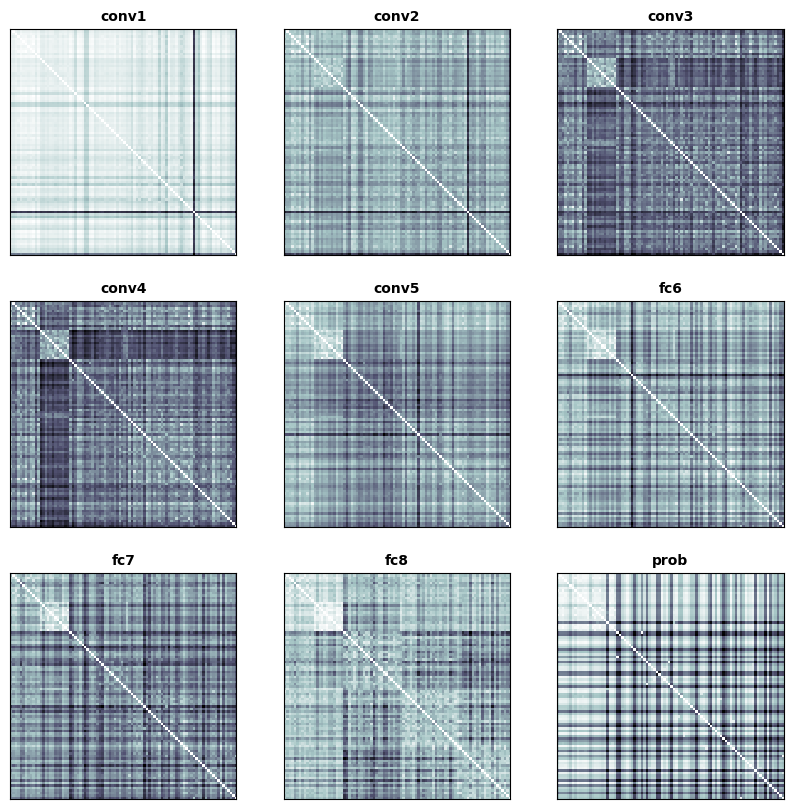

In [37]:
fig, ax, ret_val = rsatoolbox.vis.show_rdm(per_layer_rdms, rdm_descriptor='brain_computational_model', figsize=(10,10))

### Print information about a set of RDMs
The rsatoolbox objects can simply be passed to the print function to obtain a short description of their content.

In [30]:
print(per_layer_rdms)

rsatoolbox.rdm.RDMs
9 RDM(s) over 92 conditions

dissimilarity_measure = 
Euclidean

dissimilarities[0] = 
[[0.00000000e+00 7.35978432e+08 5.35502528e+08 ... 1.34278669e+09
  1.34848320e+09 4.47360614e+09]
 [7.35978432e+08 0.00000000e+00 6.72164736e+08 ... 1.52816154e+09
  1.59405773e+09 4.56825293e+09]
 [5.35502528e+08 6.72164736e+08 0.00000000e+00 ... 1.40547021e+09
  1.39483494e+09 4.35671757e+09]
 ...
 [1.34278669e+09 1.52816154e+09 1.40547021e+09 ... 0.00000000e+00
  1.85234202e+09 4.90678682e+09]
 [1.34848320e+09 1.59405773e+09 1.39483494e+09 ... 1.85234202e+09
  0.00000000e+00 5.00813875e+09]
 [4.47360614e+09 4.56825293e+09 4.35671757e+09 ... 4.90678682e+09
  5.00813875e+09 0.00000000e+00]]

descriptors: 

rdm_descriptors: 
brain_computational_model = [np.str_('conv1'), np.str_('conv2'), np.str_('conv3'), np.str_('conv4'), np.str_('conv5'), np.str_('fc6'), np.str_('fc7'), np.str_('fc8'), np.str_('prob')]
measurement_model = [np.str_('complete'), np.str_('complete'), np.str_('com

### Questions

Do you see a pattern along the layers of the model? How different are the layers?

## Step 2: Model inference

### Load data RDMs

We can now load the data. Don't mind all the fuzz, it's not important for now.

In [38]:
matlab_data = io.matlab.loadmat('data/noisyModelRDMs_A2020.mat')
repr_names_matlab = matlab_data['reprNames']
fwhms_matlab = matlab_data['FWHMs']
noise_std_matlab = matlab_data['relNoiseStds']
rdms_matlab = matlab_data['noisyModelRDMs']
repr_names = [repr_names_matlab[i][0][0] for i in range(repr_names_matlab.shape[0])]
fwhms = fwhms_matlab.squeeze().astype('float')
noise_std = noise_std_matlab.squeeze().astype('float')
rdms_matrix = rdms_matlab.squeeze().astype('float')

### Choose the data RDMs for inference

Here we choose which data RDMs we use. You can change the representation, the noise level and the amount of averaging by changing the index values at the beginning. We then convert the chosen data RDMs into an rsatoolbox RDMs object and display them as we did for the model RDMs.

The chosen ground truth model is:
conv5
with noise level:
6.0
with averaging width (full width at half magnitude):
0.0


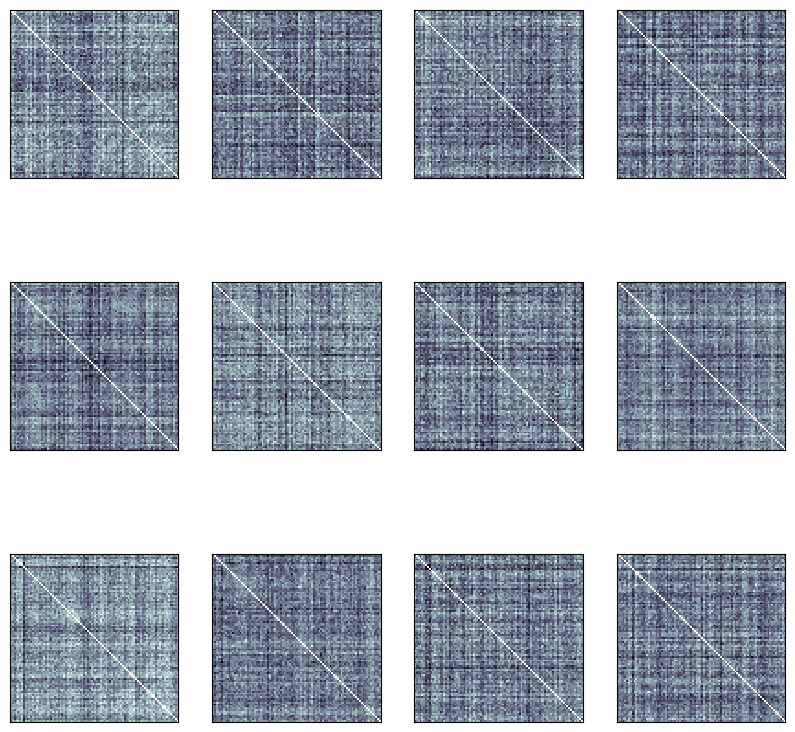

In [54]:
# indices choosing brain-computational model, noise level, and the size of the kernel with which each voxel samples the neural activity
i_rep = 4 #np.random.randint(len(repr_names)) 
i_noise = 2 #np.random.randint(len(noise_std))
i_fwhm = 0 #np.random.randint(len(fwhms))

# print the chosen representation definition
repr_name = repr_names[i_rep]
print('The chosen ground truth model is:')
print(repr_name)
print('with noise level:')
print(noise_std[i_noise])
print('with averaging width (full width at half magnitude):')
print(fwhms[i_fwhm])

# put the rdms into an RDMs object and show it
rdms_data = rsatoolbox.rdm.RDMs(rdms_matrix[:, i_rep, i_fwhm, i_noise, :].transpose())

fig, ax, ret_val = rsatoolbox.vis.show_rdm(rdms_data, figsize=(10,10))

### Define models

From the model RDMs we now create Model objects. There is a lot of magic you can do with different definitions of models, but we will now focus on a simple model that just uses the RDM as is.

In [55]:
models = []
for i_model in np.unique(model_names):
    rdm_m = model_rdms.subset('brain_computational_model', i_model)
    m = rsatoolbox.model.ModelFixed(i_model, rdm_m)
    models.append(m)

print('created the following models:')
for i in range(len(models)):
    print(models[i].name)

created the following models:
conv1
conv2
conv3
conv4
conv5
fc6
fc7
fc8
prob


### Compare model RDMs to measured RDMs
Evaluate models naively, i.e. simply compute the average correlation to the data RDMs.

(<Figure size 1250x1000 with 2 Axes>, <Axes: >, <Axes: >)

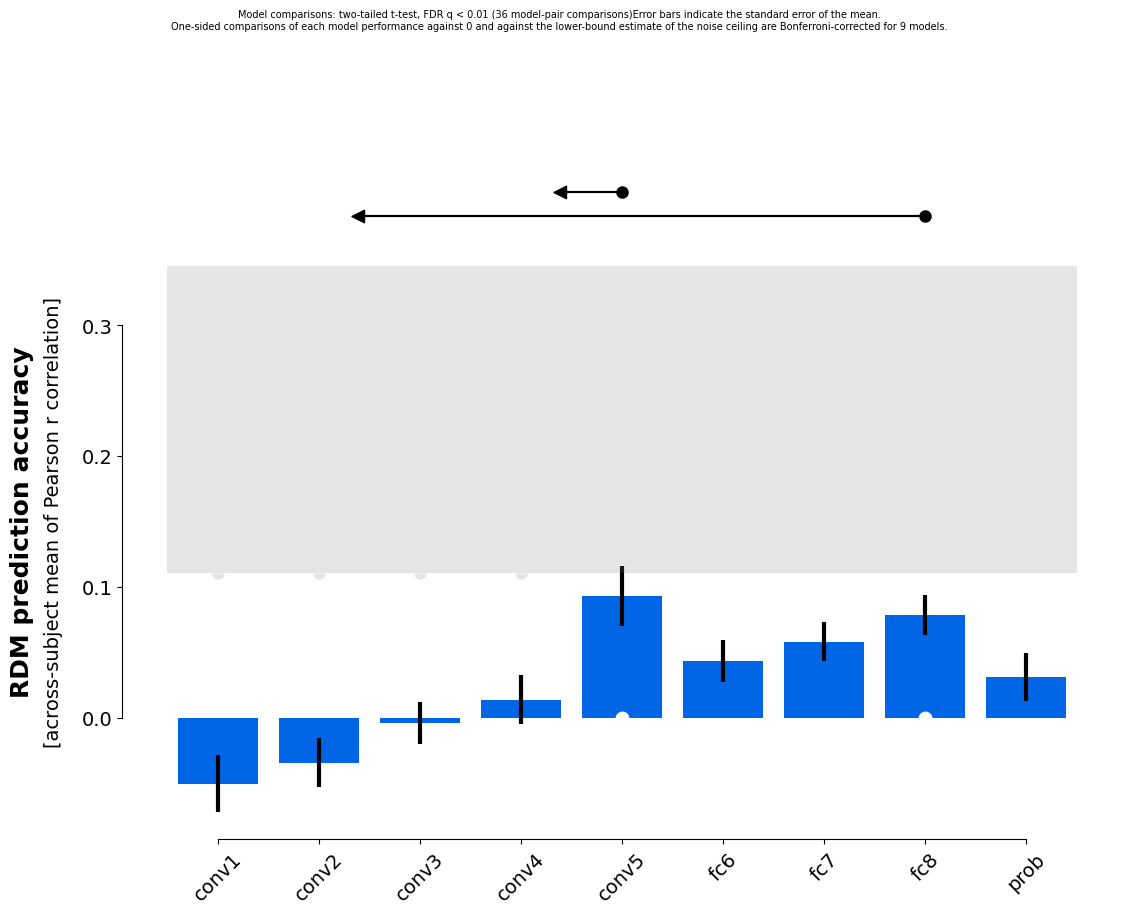

In [56]:
results_1 = rsatoolbox.inference.eval_fixed(models, rdms_data, method='corr')
rsatoolbox.vis.plot_model_comparison(results_1)

In these plots the errorbars are based on the variability across subjects, which can be handled analytically. The lines above the plot show which pairwise comparisons are significant. The upper bound of the noise ceiling is computed by finding the RDM with the highest possible average similarity to the measured RDMs. This is not 1 because the RDMs for different subjects or measurements differ. The lower bound of the noise ceiling is a leave one out crossvalidation of this averaging procedure, i.e. we find the RDM to perform optimally on all but one of the RDMs and evaluate this average RDM on the left-out RDM. Each RDM is left out once and the correlations are averaged.

### Questions
Does the right model win? Also try out different layers for data generation, at different noise levels.